# 時間序列資料學習

氣溫、股票指數、音訊等隨時間變化的資料，都是時間序列資料。對於時間序列資料，也可以用機器學習技術處理，例如:
+ 分類問題: 給一段時間序列資料，分辨它是屬於哪一類。
+ 預測問題: 給一段時間序列資料，請問接下來若干時間點，最可能的值是甚麼。

相關技術也可以應用於有前後順序性的序列資料，如文件、自然語言等。這個單元，討論時間序列資料預測問題。

(回顧)以張量安排時間序列資料，通常安排成下面方式:
<table>
    <tr><th style="text-align:center">實例</th><th style="text-align:center">樣本張量結構(shape)</th><th style="text-align:center">樣本集張量結構(shape)</th></tr>
    <tr><td style="text-align:left">樣本可用向量表示</td><td style="text-align:left">(features,)</td><td style="text-align:left">(samples,features)</td></tr>
    <tr><td style="text-align:left" ><font color='red'>(時間)序列樣本</font></td><td style="text-align:left"><font color='red'>(timesteps,features)</font></td><td style="text-align:left"><font color='red'>(samples,timesteps,features)</font></td></tr>
    <tr><td style="text-align:left">影像樣本(channel last)</td><td style="text-align:left">(height,width,channel)</td><td style="text-align:left">(samples,height,width,channel)</td></tr>
    <tr><td style="text-align:left">影像樣本(channel first)</td><td style="text-align:left">(channel,height,width)</td><td style="text-align:left">(samples,channel,height,width)</td></tr>
    <tr><td style="text-align:left">視訊樣本(channel last)</td><td style="text-align:left">(frames,height,width,channel)</td><td style="text-align:left">(samples,frames,height,width,channel)</td></tr>
    <tr><td style="text-align:left">視訊樣本(channel first)</td><td style="text-align:left">(frames,channel,height,width)</td><td style="text-align:left">(samples,frames,channel,height,width)</td></tr>
</table>

舉例，若要根據過去10個時間點資料來預測未來某個時間點目標屬性的值(例如，水溫)，假如每個時間點只有一個觀測值(例如，水溫)，那麼每一個樣本其張量結構為(10,1)。若每個時間點有3個觀測值(例如，水溫、鹽度、流速)，那麼每一個樣本其張量結構為(10,3)。

下面先用合成時間序列資料、然後再用氣溫資料集來了解整個步驟與不同的模型設計方式。

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


## 顯示時間序列資料的函式
以圖顯示時間序列資料，有助於理解資料在時間變化的趨勢。

In [ ]:
def plot_series(series, time_index=None, ax = None, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$",xticks_num=10):
    plt.plot(series, ".-")
    extend_hl = 0
    
    if ax is None:
        ax = plt
        
    if y is not None:
        if hasattr(y,'size'):
            extend_hl = max(extend_hl,y.size)
            n_steps = np.arange(y.size)+series.size
        elif isinstance(y,tf.Tensor):
            extend_hl = max(extend_hl,y.numpy().size)
            n_steps = np.arange(y.numpy().size)+series.size

        plt.plot([series.size-1,series.size],[series[-1],y[0]],'.-b')
        plt.plot(n_steps, y, "-bx", markersize=10,label='true')
        
    if y_pred is not None:
        if hasattr(y_pred,'size'):
            extend_hl = max(extend_hl,y_pred.size)
            n_steps = np.arange(y_pred.size)+series.size
        elif isinstance(y_pred,tf.Tensor):
            extend_hl = max(extend_hl,y_pred.numpy().size)     
            n_steps = np.arange(y_pred.numpy().size)+series.size
        plt.plot([series.size-1,series.size],[series[-1],y_pred[0]],'.-r')
        plt.plot(n_steps, y_pred, "-ro",label='pred')
        
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
        
    if time_index is not None:
        plt.xticks(np.linspace(0,time_index.size-1,xticks_num),['{:.02f}'.format(x) for x in np.linspace(0,time_index[-1],xticks_num)])
        plt.axis([0, time_index.size-1, -1, 1])
        
    plt.hlines(0, 0, series.size+extend_hl, linewidth=1)
    
    if y is not None or y_pred is not None:
        plt.legend()

## 範例1:使用合成時間序列資料

### 產生合成時間序列資料
假設一個sine形狀的循環訊號$sin(t)$，$t$表示時間(秒)，我們在15秒內等時間間隔取樣100點，那麼會是下面的樣子。題外話，若等時間間隔取樣5點，那會是甚麼樣子呢?

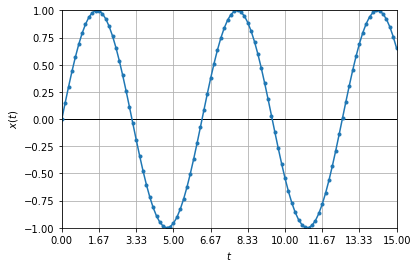

In [ ]:
n_steps    = 100
time_index = np.linspace(0,15,n_steps)
x          = np.sin(time_index)
plt.figure()
plot_series(x,time_index)
plt.show()

假設一個sine形狀的循環的訊號$sin(t+10)$，$t$表示時間(秒)，我們在0\~1秒等時間間隔取樣100點，那麼其實就是$sin(t)$在10\~11秒取樣100點的樣子。

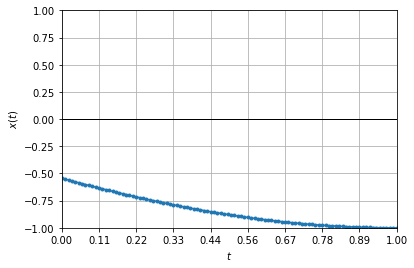

In [ ]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = np.sin(time_index+10)
plt.figure()
plot_series(x,time_index)
plt.show()

假設一個sine形狀的循環的訊號$0.5sin(10(t+10))$，$t$表示時間(秒)，我們在一秒內取樣100點，那麼會是下面的樣子。可以知道$a\times sin(b(t+c))$，$a,b,c$分別會影響訊號的震幅、週期、時間軸平移。

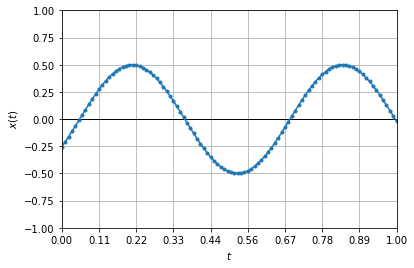

In [ ]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = 0.5*np.sin(10*(time_index+10))
plt.figure()
plot_series(x,time_index)
plt.show()

將$0.5sin(10(t+10))$與$0.25sin(20(t+20))$相加後產生另一種波形。

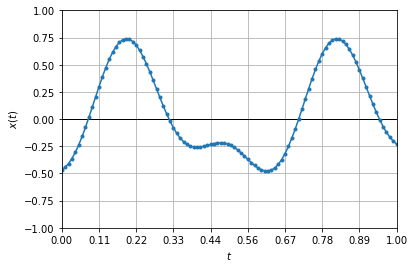

In [ ]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = 0.5*np.sin(10*(time_index+10))+0.25*np.sin(20*(time_index+20))
plt.figure()
plot_series(x,time_index)
plt.show()

通常觀察到的訊號會含有雜訊。若此雜訊為高斯雜訊$G(0.2,0.1)$以"加減"形式混入訊號裡，那麼可以用下面方式模擬，其中np.random.rand產生高斯雜訊$G(0,1)$。

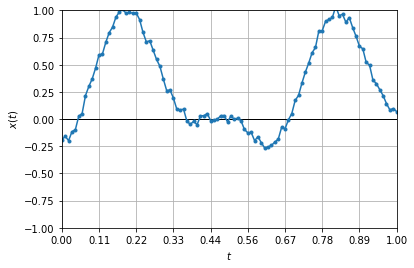

In [ ]:
n_steps    = 100
time_index = np.linspace(0,1,n_steps)
x          = 0.5*np.sin(10*(time_index+10))+0.25*np.sin(20*(time_index+20))+ (0.1 *np.random.rand(n_steps) + 0.2)
plt.figure()
plot_series(x,time_index)
plt.show()

在每產生一個樣本(含多個時間點)時，隨機改變$0.5sin(10(t+10))$與$0.25sin(20(t+20))$的週期與在時間軸位移、然後疊加、再加上高斯雜訊。如下方式產生時間序列資料樣本。(下面函式應用了張量擴張計算技巧。)

In [ ]:
def generate_samples(samples, n_steps):
    np.random.seed(9999) # 為了讓每次實驗以一樣的亂數seed產生資料
    freq1,freq2,offset1,offset2 = np.random.randn(4,samples,1)
    time_index = np.reshape(np.linspace(0,1,n_steps),(1,-1))
    x          = 0.5*np.sin((10+10*freq1)*(time_index+offset1+10))+\
                 0.25*np.sin((20+20*freq2)*(time_index+offset2+20))+\
                 (0.1 * np.random.rand(samples,n_steps) + 0.2)
    return x[..., np.newaxis].astype(np.float32)

顯示4個樣本，每個樣本含100時間點。可以看到，那4個樣本差距還蠻顯著的。

samples.shape =  (4, 100, 1)


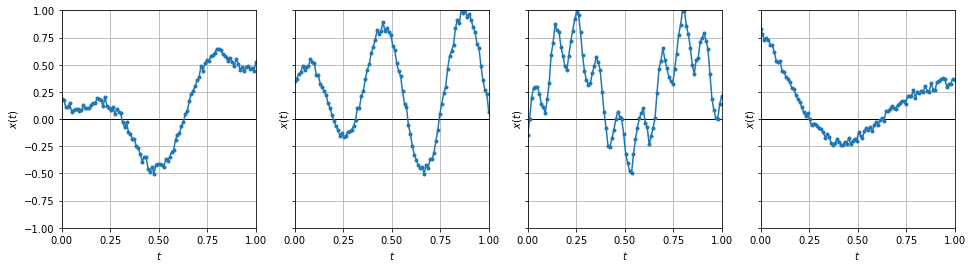

In [ ]:
samples = generate_samples(4,100)
print('samples.shape = ',samples.shape)

fig,axes = plt.subplots(1,4,sharey=True,figsize=(16,4),squeeze=True)
for idx,ax in enumerate(axes):
    plt.sca(ax)
    freq1,freq2,offset1,offset2 = np.random.randn(4)
    time_index = np.linspace(0,1,n_steps)
    plot_series(samples[idx],time_index,xticks_num=5)
plt.show()

### 預測未來一個時間點的值

接下來我們打算用連續50個時間點資料來預測下個時間點的值。

#### 評估指標
+ mean squared error (MSE) = $\frac{1}{n}\sum_{i=1}^{n}(y\_true_{i}-y\_pred_{i})^{2}$
  + tf.keras.losses.MSE(y_true, y_pred)
+ mean absolute error (MAE) = $\frac{1}{n}\sum_{i=1}^{n}|y\_true_{i}-y\_pred_{i}|$
  + tf.keras.losses.MAE(y_true, y_pred)

#### 準備訓練、驗證、測試樣本

In [ ]:
n_steps = 50
samples = generate_samples(10000,n_steps+1)
X_train = samples[:7000,:n_steps]
y_train = samples[:7000,-1]
X_valid = samples[7000:9000,:n_steps]
y_valid = samples[7000:9000,-1]
X_test  = samples[9000:,:n_steps]
y_test  = samples[9000:,-1]

print(samples.shape,X_train.shape,y_train.shape)

(10000, 51, 1) (7000, 50, 1) (7000, 1)


#### 建立預測函數
會嘗試下面幾個預測函數
1. The last value
2. Mean
3. Linear regression
4. Neural Network with one Dense layer
5. Neural Network with one SimpleRNN layer
6. Neural Network with three SimpleRNN layers 
7. Neural Network with three SimpleRNN layers and one dense layer

#### 預測函數1:用前一時刻的值當作預測值
$y_{i}=x_{i50}$

<font color="red">預測函數1簡單而且可以成為評估其他方法的基準。</font>

(1000, 50, 1)
(1000, 1)
MSE: 0.020201461


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


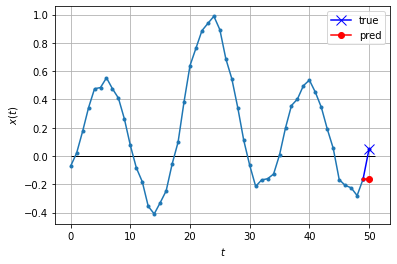

In [ ]:
print(X_test.shape)
print(X_test[:,-1].shape)

y_pred_1 = X_test[:,-1] # you are using all the rows and only the last column
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_1)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_1[0])

#### 預測函數2:用平均值來預測下一時刻
$y_{i} = \frac{1}{50}\sum_{j=1}^{50}x_{ij}$

MSE: 0.15167175


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


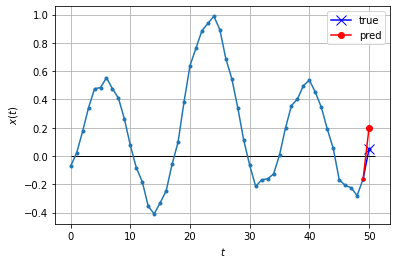

In [ ]:
y_pred_2 = tf.reduce_mean(X_test,axis=1)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_2)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_2[0])

#### 預測函數3:線性迴歸
$y_{i}=a_{1}x_{i1}+...+a_{50}x_{i50}+b\Rightarrow y_{i}=\begin{bmatrix}x_{i1},...,x_{i50},1\end{bmatrix}\begin{bmatrix} a_{1} \\ ... \\ a_{50} \\ b \end{bmatrix}\Rightarrow\mathbf{y}=\mathbf{X}\mathbf{a}$

MSE 0.008406538411198943


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


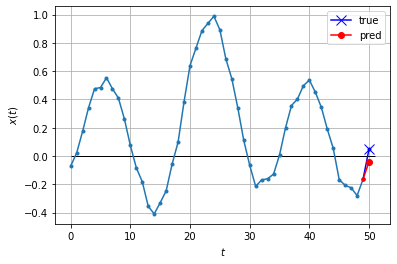

In [ ]:
X = np.hstack([np.reshape(X_train,(-1,50)), np.ones((X_train.shape[0],1))])
a = np.linalg.lstsq(X, y_train.ravel(), rcond=None)[0]
y_pred_3 = np.dot(np.hstack([np.reshape(X_test,(-1,50)), np.ones((X_test.shape[0],1))]),np.reshape(a,(-1,1)))
print('MSE',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_3)).numpy())                

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_3[0])

#### 預測函數4:一層全連接層的類神經網路

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(50,1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1692 - val_loss: 0.0847
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0465
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0350
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0293
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0257
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0229
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0207
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0190
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0180 - val_loss: 0.0165

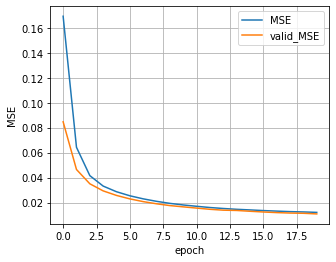

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE 0.011235095


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


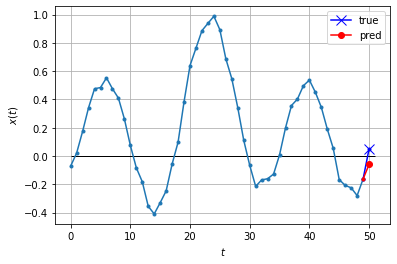

In [ ]:
y_pred_4 = model.predict(X_test)
print('MSE',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_4)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_4[0])

#### 預測函數5:簡單RNN
下面顯示一個簡單的遞迴類神經單元，他會將上一個時刻的輸出$\mathbf{y}_{t-1}$匯回與這個時刻的輸入$\mathbf{x}_{t}$一起當作輸入。
<div>
<img src="attachment:simple_rnn.png" width="200">
</div>    
注意SimpleRNN的觸發函數預設為tanh。若要嘗試GRU或LSTM，可置換SimpleRNN。

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 1.2894 - val_loss: 1.2219
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.9897 - val_loss: 0.7694
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.5931 - val_loss: 0.4677
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.4259 - val_loss: 0.3656
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.3387 - val_loss: 0.2895
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.2668 - val_loss: 0.2283
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.2105 - val_loss: 0.1812
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1668 - val_loss: 0.1437
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1317 - val_loss: 0.1129
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1026 - val_loss: 0.0870

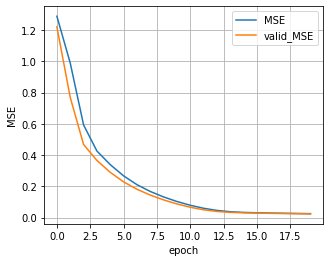

In [ ]:
srnn_model = tf.keras.models.Sequential()
srnn_model.add(tf.keras.layers.SimpleRNN(1, input_shape =[ None, 1]) )
srnn_model.compile(loss="mse", optimizer="adam")
history = srnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.022819374


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


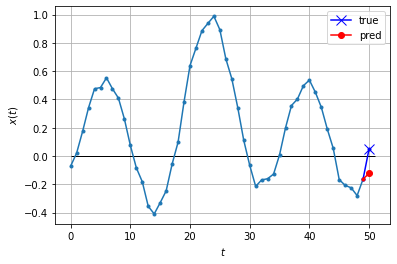

In [ ]:
y_pred_5 = srnn_model.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_5)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_5[0])

#### Simple LSTM

Epoch 1/20
219/219 [==============================] - 7s 21ms/step - loss: 0.0978 - val_loss: 0.0680
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0648 - val_loss: 0.0561
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0551 - val_loss: 0.0483
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0475 - val_loss: 0.0417
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0411 - val_loss: 0.0363
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0358 - val_loss: 0.0318
Epoch 7/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0315 - val_loss: 0.0281
Epoch 8/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0280 - val_loss: 0.0250
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0251 - val_loss: 0.0225
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0227 - val_lo

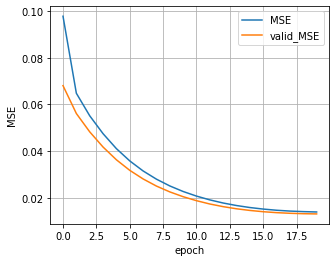

In [ ]:
## LSTM
srnn_model = tf.keras.models.Sequential()
srnn_model.add(tf.keras.layers.LSTM(1, input_shape =[ None, 1]) )
srnn_model.compile(loss="mse", optimizer="adam")
history = srnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.012992045


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


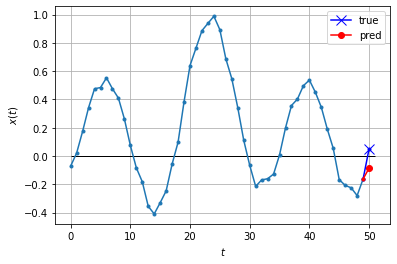

In [ ]:
y_pred_5 = srnn_model.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_5)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_5[0])

#### 預測函數6:多堆疊幾層SimpleRNN
+ 下面前兩個SimpleRNN之return_sequences要設成True，以便每個時間點的輸出都會給下一層，不然只會有最後一個時間點的輸出。舉例，若輸入是50個時間點，那麼下面的輸出shape會是(50,20)。若return_sequences設成False，那麼輸出為(20,)


         tf.keras.layers.SimpleRNN(20, return_sequences=True)
         
         

Epoch 1/20
219/219 [==============================] - 8s 28ms/step - loss: 0.0265 - val_loss: 0.0130
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0100 - val_loss: 0.0089
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0097 - val_loss: 0.0088
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0084 - val_lo

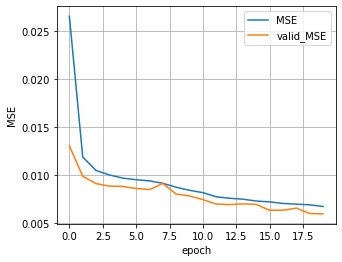

In [ ]:
drnn_model = tf.keras.models.Sequential()
drnn_model.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape =[ None, 1]) )
drnn_model.add(tf.keras.layers.SimpleRNN(15, return_sequences=True) )
drnn_model.add(tf.keras.layers.SimpleRNN(1) )
drnn_model.compile(loss="mse", optimizer="adam")
history = drnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.0060889837


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


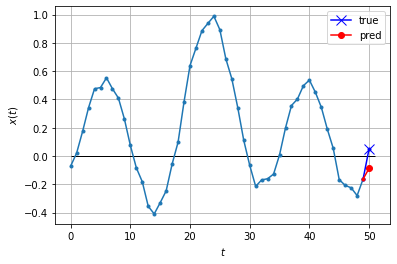

In [ ]:
y_pred_6 = drnn_model.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_6)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_6[0])

由於drnn_model沒限制每一段序列長度。我們來比較看看，50時間點、40時間點、30時間點、20時間點、10時間點的預測準確度。看來約最近的30時間點來預測就夠了。

#### 多堆疊幾層的SimpleLSTM

Epoch 1/20
219/219 [==============================] - 20s 65ms/step - loss: 0.1293 - val_loss: 0.0661
Epoch 2/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0325 - val_loss: 0.0171
Epoch 3/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0144 - val_loss: 0.0110
Epoch 4/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0116 - val_loss: 0.0103
Epoch 5/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 6/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 7/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 8/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 9/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 10/20
219/219 [==============================] - 15s 69ms/step - loss: 0.009

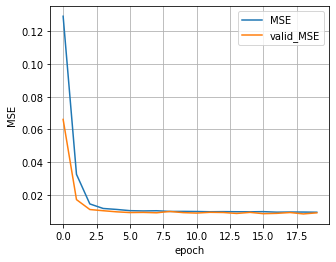

In [ ]:
drnn_model = tf.keras.models.Sequential()
drnn_model.add(tf.keras.layers.LSTM(15, return_sequences=True, input_shape =[ None, 1]) )
drnn_model.add(tf.keras.layers.LSTM(15, return_sequences=True) )
drnn_model.add(tf.keras.layers.LSTM(1) )
drnn_model.compile(loss="mse", optimizer="adam")
history = drnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.008580292


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


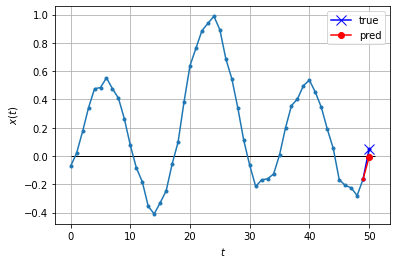

In [ ]:
y_pred_6 = drnn_model.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_6)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_6[0])

In [ ]:
for n_steps in [50,40,30,20,10]:
    y_p = drnn_model.predict(X_train[:,50-n_steps:])
    tr_mse = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_p)).numpy()
    y_p = drnn_model.predict(X_test[:,50-n_steps:])
    te_mse = tf.reduce_mean(tf.keras.losses.MSE(y_test, y_p)).numpy()
    print('MSE (n_steps:{}):train {:.4f} test {:.4f}'.format(n_steps,tr_mse,te_mse))

MSE (n_steps:50):train 0.0065 test 0.0061
MSE (n_steps:40):train 0.0065 test 0.0061
MSE (n_steps:30):train 0.0065 test 0.0062
MSE (n_steps:20):train 0.0068 test 0.0064
MSE (n_steps:10):train 0.0118 test 0.0109


#### 預測函數7:改變一下輸出層為全連接層。 

Epoch 1/20
219/219 [==============================] - 8s 29ms/step - loss: 0.0396 - val_loss: 0.0143
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0123 - val_loss: 0.0097
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 8/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 9/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0089 - val_lo

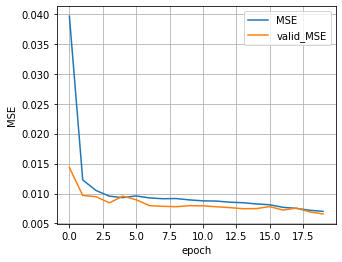

In [ ]:
drnn_model2 = tf.keras.models.Sequential()
drnn_model2.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape =[None, 1]) )
drnn_model2.add(tf.keras.layers.SimpleRNN(15, return_sequences=True) )
drnn_model2.add(tf.keras.layers.SimpleRNN(15))
drnn_model2.add(tf.keras.layers.Dense(1) )
drnn_model2.compile(loss="mse", optimizer="adam")
history = drnn_model2.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.00696295


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


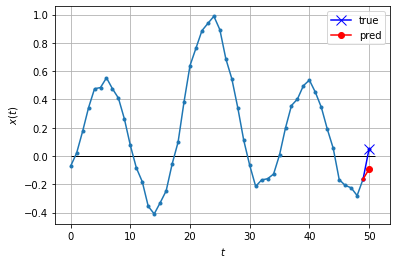

In [ ]:
y_pred_7 = drnn_model2.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_7)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_7[0])

#### LSTM 改變一下輸出層為全連接層

Epoch 1/20
219/219 [==============================] - 26s 76ms/step - loss: 0.1400 - val_loss: 0.0655
Epoch 2/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0198 - val_loss: 0.0084
Epoch 3/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 4/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 5/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 6/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 7/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 8/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 9/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 10/20
219/219 [==============================] - 14s 62ms/step - loss: 0.008

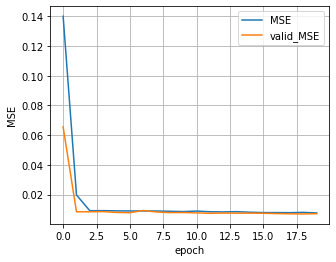

In [ ]:
drnn_model2 = tf.keras.models.Sequential()
drnn_model2.add(tf.keras.layers.LSTM(15, return_sequences=True, input_shape =[None, 1]) )
drnn_model2.add(tf.keras.layers.LSTM(15, return_sequences=True) )
drnn_model2.add(tf.keras.layers.LSTM(15))
drnn_model2.add(tf.keras.layers.Dense(1) )
drnn_model2.compile(loss="mse", optimizer="adam")
history = drnn_model2.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MSE: 0.0070528956


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


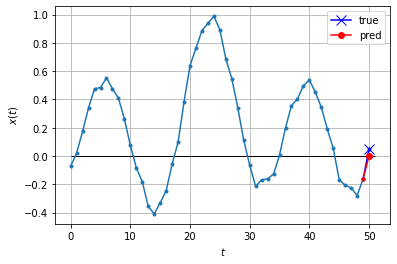

In [ ]:
y_pred_7 = drnn_model2.predict(X_test)
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_7)).numpy())

plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_7[0])

#### 比較7個預測函數

In [ ]:
for y_p,name in [(y_pred_5,'SimpleRNN'),\
 (y_pred_6,'RNN/RNN/RNN'),(y_pred_7,'RNN/RNN/RNN/Dense')]:
    print('Method:{:<25s} MSE:{:.3f}'.format(name,tf.reduce_mean(tf.keras.losses.MSE(y_test, y_p)).numpy()))

Method:The last value            MSE:0.020
Method:Average                   MSE:0.152
Method:Linear Regression         MSE:0.008
Method:Dense                     MSE:0.011
Method:SimpleRNN                 MSE:0.023
Method:RNN/RNN/RNN               MSE:0.006
Method:RNN/RNN/RNN/Dense         MSE:0.007


#### 比較3個LSTM

In [ ]:
for y_p,name in [(y_pred_5,'SimpleLSTM'),\
 (y_pred_6,'LSTM/LSTM/LSTM'),(y_pred_7,'LSTM/LSTM/LSTM/Dense')]:
    print('Method:{:<25s} MSE:{:.3f}'.format(name,tf.reduce_mean(tf.keras.losses.MSE(y_test, y_p)).numpy()))

Method:SimpleLSTM                MSE:0.013
Method:LSTM/LSTM/LSTM            MSE:0.009
Method:LSTM/LSTM/LSTM/Dense      MSE:0.007


### 預測多個時間點
假設往前預測5個時間點的值。
+ 方法1:在不修改上面模型的狀況下，可以將預測的下個時間點當作資料，與原本資料串接後，用來預測下下個時刻。以此類推可以往前預測多個時間點。
<div>
<img src="attachment:multiple_pt_rnn_m1.png" width="300">
</div>
+ 方法2:直接擴充輸出層輸出單元數，訓練一次可以預測多個未來時間點的模型。
<div>
<img src="attachment:multiple_pt_rnn_m2.png" width="250">
</div>
+ 方法3:建立遞迴類神經網路，訓練他在第$x_{i1}$時間點輸出$x_{i2},...,x_{i6}$,在第二時間點$x_{i2}$輸出$x_{i3},...,x_{i7}$，...,在第50時間點輸出$x_{i51},...,x_{i55}$。對一個測試序列，取最後一時間點的輸出為預測結果。
<div>
<img src="attachment:multiple_pt_rnn_m3.png" width="220">
</div>

下面例子先示範用方法1往前預測5點。

#### 方法1

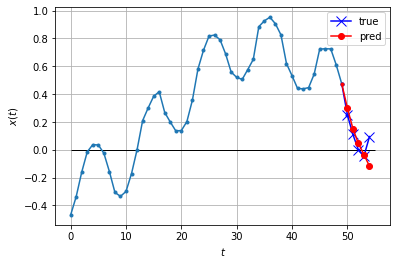

In [ ]:
n_steps    = 50
new_sample = generate_samples(1,n_steps+5)
X_new      = new_sample[:,:n_steps]
for _ in range(1,6):
    y_pred = drnn_model2.predict(X_new)
    X_new  = np.concatenate([X_new[:,1:], y_pred[:,:,np.newaxis]],axis=1)
plot_series(new_sample[0,:n_steps],y=new_sample[0,n_steps:],y_pred=X_new[0,-5:])                            

#### 方法2
準備訓練資料。

In [ ]:
n_steps = 50
samples2 = generate_samples(10000,n_steps+5)
X_train2 = samples2[:7000,:n_steps]
y_train2 = samples2[:7000,n_steps:,0]
X_valid2 = samples2[7000:9000,:n_steps]
y_valid2 = samples2[7000:9000,n_steps:,0]
X_test2  = samples2[9000:,:n_steps]
y_test2  = samples2[9000:,n_steps:,0]

In [ ]:
print(samples[:7000,n_steps:,0].shape)

(7000, 1)


Epoch 1/20
219/219 [==============================] - 8s 29ms/step - loss: 0.1008 - val_loss: 0.0724
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0709 - val_loss: 0.0635
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0654 - val_loss: 0.0589
Epoch 4/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0616 - val_loss: 0.0572
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0574 - val_loss: 0.0503
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0547 - val_loss: 0.0480
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0528 - val_loss: 0.0476
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0493 - val_loss: 0.0439
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0464 - val_loss: 0.0516
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0459 - val_l

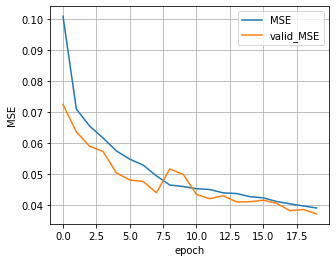

In [ ]:
drnn_model3 = tf.keras.models.Sequential()
drnn_model3.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape =[None, 1]) )
drnn_model3.add(tf.keras.layers.SimpleRNN(15, return_sequences=True) )
drnn_model3.add(tf.keras.layers.SimpleRNN(15))
drnn_model3.add(tf.keras.layers.Dense(5) )
drnn_model3.compile(loss="mse", optimizer="adam")
history = drnn_model3.fit(X_train2, y_train2, epochs=20,validation_data=(X_valid2, y_valid2))

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


MSE: 0.039123442


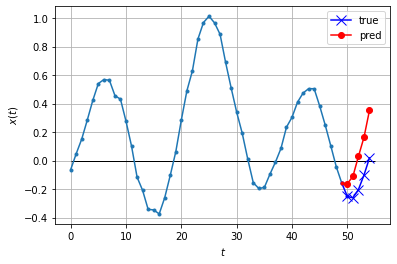

In [ ]:
y_pred_mpt_2 = drnn_model3.predict(X_test2)
plot_series(X_test2[0],y=y_test2[0],y_pred=y_pred_mpt_2[0])  
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test2, y_pred_mpt_2)).numpy())

#### 方法3
準備訓練資料。

In [ ]:
n_steps  = 50
samples3 = generate_samples(10000, n_steps + 5)
X_train3 = samples3[:7000, :n_steps]
X_valid3 = samples3[7000:9000, :n_steps]
X_test3  = samples3[9000:, :n_steps]
y        = np.empty((10000, n_steps, 5))
for step_ahead in range(1, 5 + 1):
    y[..., step_ahead - 1] = samples3[..., step_ahead:step_ahead + n_steps, 0]
y_train3 = y[:7000]
y_valid3 = y[7000:9000]
y_test3  = y[9000:]

In [ ]:
mp_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(15, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(15, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5))
])
mp_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, None, 15)          255       
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, None, 15)          465       
                                                                 
 time_distributed (TimeDistr  (None, None, 5)          80        
 ibuted)                                                         
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def last_timestep_mse(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

mp_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=[last_timestep_mse])
history = mp_model.fit(X_train3, y_train3, epochs=20,validation_data=(X_valid3, y_valid3))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


219/219 [==============================] - 6s 20ms/step - loss: 0.0786 - last_timestep_mse: 0.0772 - val_loss: 0.0678 - val_last_timestep_mse: 0.0629
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0637 - last_timestep_mse: 0.0603 - val_loss: 0.0526 - val_last_timestep_mse: 0.0467
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0502 - last_timestep_mse: 0.0436 - val_loss: 0.0457 - val_last_timestep_mse: 0.0377
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0448 - last_timestep_mse: 0.0380 - val_loss: 0.0418 - val_last_timestep_mse: 0.0330
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0420 - last_timestep_mse: 0.0346 - val_loss: 0.0406 - val_last_timestep_mse: 0.0322
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0404 - last_timestep_mse: 0.0327 - val_loss: 0.0383 - val_last_timestep_mse: 0.0300
Epoch 7/20
219/219 [=========================

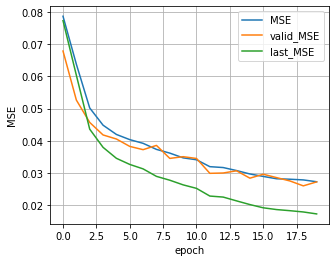

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.plot(history.history['last_timestep_mse'],label='last_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


MSE: 0.018082673730248515


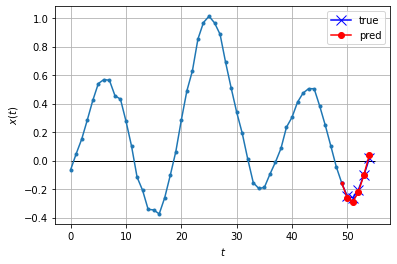

In [ ]:
y_pred_mpt_3 = mp_model.predict(X_test3)[:,-1]
plot_series(X_test3[0],y=y_test3[0,-1],y_pred=y_pred_mpt_3[0])  
print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_pred_mpt_3,y_test3[:,-1,:])).numpy())

## 天氣資料集
這個天氣資料集(<a href="https://www.bgc-jena.mpg.de/wetter/" target="_blank">資料來源</a>)包含從2003年起，每隔10分鐘紀錄如大氣溫度、壓力、濕度等14個天氣觀測值。在Tensorflow<a href="https://www.tensorflow.org/tutorials/structured_data/time_series" target="_blank">官方範例</a>及François Chollet的<a href="https://www.manning.com/books/deep-learning-with-python" target="_blank">書</a>裡都有使用這個資料集示範溫度預測。

#### 下載資料檔
2009~2016年紀錄。

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
filename = os.path.splitext(zip_path)[0]

13574144/13565642 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(filename)

每筆紀錄含時間戳記與14項觀測值。每筆紀錄間隔10分鐘。

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


[0, 52558, 105262, 157822, 210526, 263085, 315732, 368192]


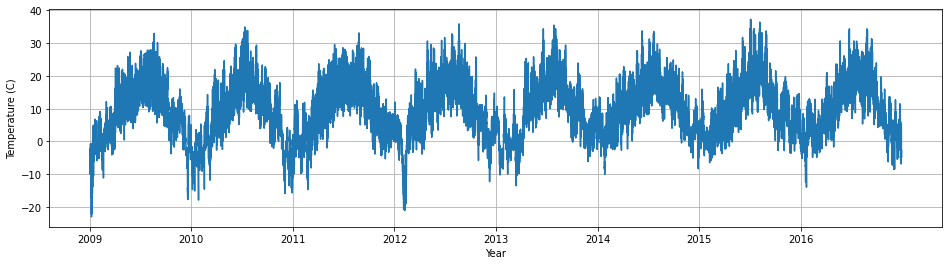

In [ ]:
# for year in range(2009,2017):

year_idx = list()
for j in range(2009,2017):
    for i in range(len(df)):
        if (df['Date Time'].iloc[i] == '01.01.{} 00:10:00'.format(j)):
            year_idx.append(i)

print(year_idx)

# year_idx  = [np.argwhere(df['Date Time'] == '01.01.{} 00:10:00'.format(year)).ravel()[0] for year in range(2009,2017)]
year_label= [str(year) for year in range(2009,2017)]
temperature_df       = df['T (degC)']
temperature_df.index = df['Date Time']
ax = temperature_df.plot(xticks=year_idx,rot=0,figsize=(16,4))
ax.set_xticklabels(year_label)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')
ax.grid(True)

顯示那幾年1月份氣溫變化。

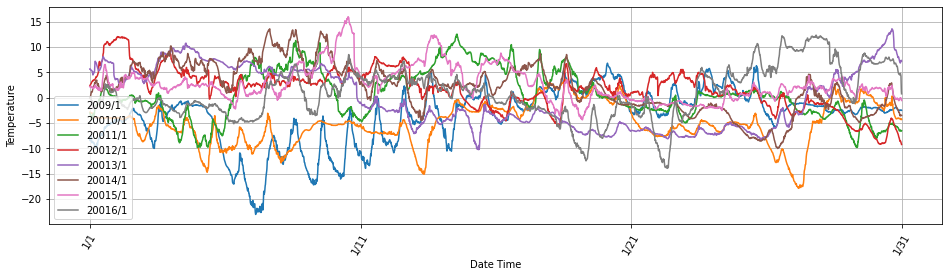

In [ ]:
for y,year_start in enumerate(year_idx):
    ax = temperature_df[year_start:year_start+4320].plot(rot=60,figsize=(16,4),label='200{}/1'.format(y+9))
    ax.grid(True)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Date Time')
ax.set_xticks([6*24*10*i for i in range(0,4)])
ax.set_xticklabels(['1/{}'.format(i*10+1) for i in range(0,4)])    
ax.legend();

若只想用過去溫度預測未來溫度，可以用下面指令取得溫度資料並轉成numpy array。

In [ ]:
temperature_data = temperature_df.values
print(temperature_data.shape)

(420451,)


### 應用過去5天的氣壓(p)、氣溫(T)、大氣密度($\rho$)，來預測未來12小時氣溫變化
採用方法2做多時間點預測。

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [ ]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


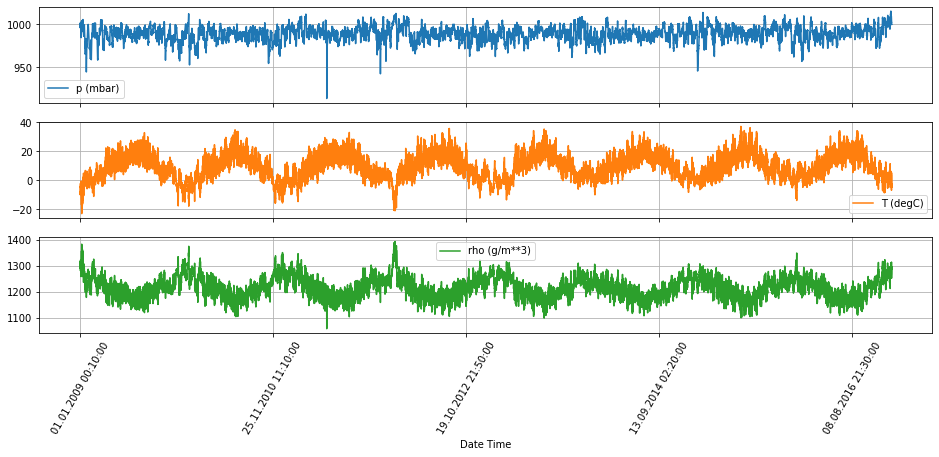

In [ ]:
ax=features.plot(subplots=True,figsize=(16,6),rot=60)
for a in ax:
    a.grid(True)

In [ ]:
print(features)
dataset   = features.values
print(dataset.shape)

train_timesteps = 5*24*6
target_timesteps= 12*6
total_steps     = train_timesteps+target_timesteps
wind            = dataset.shape[0]//total_steps
train_dt  = dataset[:total_steps*(wind*3//4)]
valid_dt  = dataset[-total_steps*(wind-wind*3//4):]

train_mean = np.mean(train_dt,axis=0)
train_std  = np.std(train_dt,axis=0)
print(train_dt.shape,valid_dt.shape)

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00
...                       ...       ...           ...
31.12.2016 23:20:00   1000.07     -4.05       1292.98
31.12.2016 23:30:00    999.93     -3.35       1289.44
31.12.2016 23:40:00    999.82     -3.16       1288.39
31.12.2016 23:50:00    999.81     -4.23       1293.56
01.01.2017 00:00:00    999.82     -4.82       1296.38

[420451 rows x 3 columns]
(420451, 3)
(314424, 3) (105336, 3)


#### 資料前處理
這三個觀測值的數值範圍差距很大，可以使用前處理方式，讓它們各自平均值與標準差變成0與1。

In [ ]:
def Scalar(x,y):
    return (x[...,:] - train_mean)/train_std,(y-train_mean[1])/train_std[1]

In [ ]:
BATCH_SIZE = 4
EPOCHS     = 30
steps      = 1
train_dt   = np.reshape(train_dt,(-1,total_steps,3))
valid_dt   = np.reshape(valid_dt,(-1,total_steps,3))

TRAIN_STEP_PER_EPOCH = train_dt.shape[0]//BATCH_SIZE
VALID_STEP_PER_EPOCH = valid_dt.shape[0]//BATCH_SIZE

X_train    = train_dt[:,:train_timesteps:steps,:]
y_train    = train_dt[:,train_timesteps:,1]
print(X_train.shape)
print(y_train.shape)

X_valid    = valid_dt[:,:train_timesteps:steps,:]
y_valid    = valid_dt[:,train_timesteps:,1]

train_ds   = tf.data.Dataset.from_tensor_slices((X_train,y_train))

print(train_ds)
train_ds   = train_ds.map(Scalar).cache().shuffle(1000).batch(BATCH_SIZE).repeat()
valid_ds   = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
valid_ds   = valid_ds.map(Scalar).batch(BATCH_SIZE).repeat()




(397, 720, 3)
(397, 72)
<TensorSliceDataset element_spec=(TensorSpec(shape=(720, 3), dtype=tf.float64, name=None), TensorSpec(shape=(72,), dtype=tf.float64, name=None))>


#### 建立類神經網路架構
第一層使用AveragePooling1D的目的是將輸入每一小時有6個時間點，降成1個。接下來堆疊兩個LSTM，然後用全連接層輸出未來12小時溫度變化。

In [ ]:
temperature_model = tf.keras.models.Sequential()
temperature_model.add(tf.keras.layers.AveragePooling1D(6,input_shape=[None,3]))
temperature_model.add(tf.keras.layers.LSTM(32,return_sequences=True))
temperature_model.add(tf.keras.layers.LSTM(72,dropout=0.2,recurrent_dropout=0.2))
temperature_model.add(tf.keras.layers.Dense(72))

temperature_model.compile(loss='mean_absolute_error', optimizer="adam")

In [ ]:
history = temperature_model.fit(train_ds, epochs=EPOCHS,steps_per_epoch=TRAIN_STEP_PER_EPOCH,validation_data=valid_ds,validation_steps=VALID_STEP_PER_EPOCH)

Epoch 1/30
99/99 [==============================] - 60s 522ms/step - loss: 0.5171 - val_loss: 0.4160
Epoch 2/30
99/99 [==============================] - 58s 578ms/step - loss: 0.4124 - val_loss: 0.4112
Epoch 3/30
99/99 [==============================] - 47s 470ms/step - loss: 0.3881 - val_loss: 0.3938
Epoch 4/30
99/99 [==============================] - 48s 481ms/step - loss: 0.3673 - val_loss: 0.3983
Epoch 5/30
99/99 [==============================] - 46s 469ms/step - loss: 0.3139 - val_loss: 0.3782
Epoch 6/30
99/99 [==============================] - 46s 467ms/step - loss: 0.2717 - val_loss: 0.3297
Epoch 7/30
99/99 [==============================] - 47s 474ms/step - loss: 0.2431 - val_loss: 0.3135
Epoch 8/30
99/99 [==============================] - 47s 473ms/step - loss: 0.2264 - val_loss: 0.3132
Epoch 9/30
99/99 [==============================] - 47s 471ms/step - loss: 0.2225 - val_loss: 0.3252
Epoch 10/30
99/99 [==============================] - 48s 486ms/step - loss: 0.2274 - val_lo

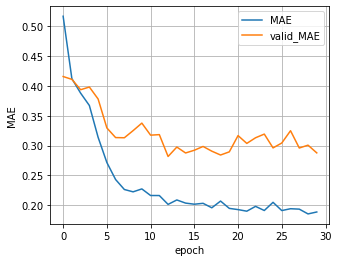

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MAE')
plt.plot(history.history['val_loss'],label='valid_MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

MAE: 0.7355848571989272


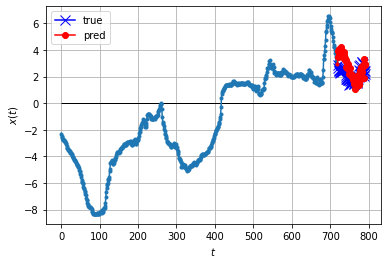

In [ ]:
for x, y in valid_ds.take(1):
    y_pred = temperature_model.predict(x)[0]
    print(y_pred)
    plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred*train_std[1]+train_mean[1])  
    print('MAE:',tf.reduce_mean(tf.keras.losses.MAE(y_pred*train_std[1]+train_mean[1],y[0]*train_std[1]+train_mean[1])).numpy())

# Simple RNN

In [ ]:
# simple RNN
srnn_model = tf.keras.models.Sequential()
srnn_model.add(tf.keras.layers.SimpleRNN(72, input_shape =[ None, 3]) )

# temperature_model.add(tf.keras.layers.AveragePooling1D(6,input_shape=[None,3]))

srnn_model.compile(loss="mse", optimizer="adam")
# history = srnn_model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))
history = srnn_model.fit(train_ds, epochs=EPOCHS,steps_per_epoch=TRAIN_STEP_PER_EPOCH, validation_data=valid_ds, validation_steps=VALID_STEP_PER_EPOCH) # 改

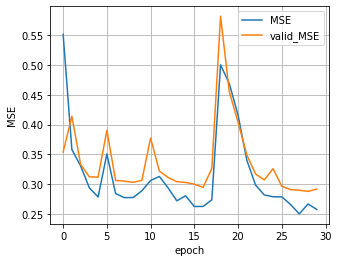

MAE: 0.609569691022237


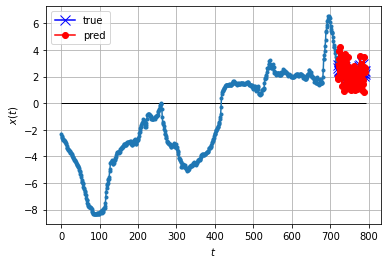

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

# y_pred_5 = srnn_model.predict(X_test)
# print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_5)).numpy())

# plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_5[0])

for x, y in valid_ds.take(1):
    y_pred = srnn_model.predict(x)[0]
    plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred*train_std[1]+train_mean[1])  
    print('MAE:',tf.reduce_mean(tf.keras.losses.MAE(y_pred*train_std[1]+train_mean[1],y[0]*train_std[1]+train_mean[1])).numpy())

# Neural Network with three SimpleRNN layers

In [ ]:
drnn_model = tf.keras.models.Sequential()
drnn_model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape =[ None, 3]) )
drnn_model.add(tf.keras.layers.SimpleRNN(72, return_sequences=True)
drnn_model.add(tf.keras.layers.SimpleRNN(72) )
drnn_model.compile(loss="mse", optimizer="adam")
history = drnn_model.fit(train_ds, epochs=EPOCHS,steps_per_epoch=TRAIN_STEP_PER_EPOCH, validation_data=valid_ds, validation_steps=VALID_STEP_PER_EPOCH) # 改




Epoch 1/30
99/99 [==============================] - 181s 2s/step - loss: 0.4069 - val_loss: 0.3157
Epoch 2/30
99/99 [==============================] - 174s 2s/step - loss: 0.2847 - val_loss: 0.3039
Epoch 3/30
99/99 [==============================] - 223s 2s/step - loss: 0.2630 - val_loss: 0.2767
Epoch 4/30
99/99 [==============================] - 214s 2s/step - loss: 0.2398 - val_loss: 0.2794
Epoch 5/30
99/99 [==============================] - 173s 2s/step - loss: 0.2512 - val_loss: 0.2860
Epoch 6/30
99/99 [==============================] - 174s 2s/step - loss: 0.2461 - val_loss: 0.2934
Epoch 7/30
67/99 [===================>..........] - ETA: 1:02 - loss: 0.2654

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

# y_pred_6 = drnn_model.predict(X_test)
# print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_6)).numpy())

# plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_6[0]

for x, y in valid_ds.take(1):
    y_pred = drnn_model.predict(x)[0]
    plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred*train_std[1]+train_mean[1])  
    print('MAE:',tf.reduce_mean(tf.keras.losses.MAE(y_pred*train_std[1]+train_mean[1],y[0]*train_std[1]+train_mean[1])).numpy())

# Neural Network with three SimpleRNN layers and one dense layer

In [ ]:
drnn_model2 = tf.keras.models.Sequential()
drnn_model2.add(tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape =[None, 3]) )
drnn_model2.add(tf.keras.layers.SimpleRNN(72, return_sequences=True) )
drnn_model2.add(tf.keras.layers.SimpleRNN(72))
drnn_model2.add(tf.keras.layers.Dense(72) )
drnn_model2.compile(loss="mse", optimizer="adam")
history = drnn_model2.fit(train_ds, epochs=EPOCHS,steps_per_epoch=TRAIN_STEP_PER_EPOCH, validation_data=valid_ds, validation_steps=VALID_STEP_PER_EPOCH) # 改


plt.figure(figsize=(5,4))
plt.plot(history.history['loss'],label='MSE')
plt.plot(history.history['val_loss'],label='valid_MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# y_pred_7 = drnn_model2.predict(X_test)
# print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_7)).numpy())

# plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_7[0])

for x, y in valid_ds.take(1):
    y_pred = drnn_model2.predict(x)[0]
    plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred*train_std[1]+train_mean[1])  
    print('MAE:',tf.reduce_mean(tf.keras.losses.MAE(y_pred*train_std[1]+train_mean[1],y[0]*train_std[1]+train_mean[1])).numpy())

# last value

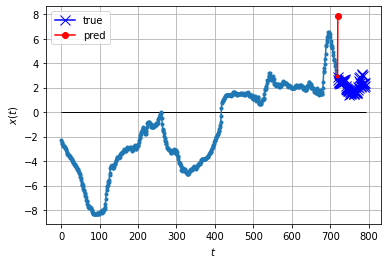

In [ ]:
# last value

for x, y in valid_ds.take(1):
    y_pred = x[-4]
    # top
    plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred_1[0]*train_std[1]+train_mean[1])
    
    # down
    # plot_series(x[0].numpy()[:,1]*train_std[1]+train_mean[1],y=y[0].numpy()*train_std[1]+train_mean[1],y_pred=y_pred*train_std[1]+train_mean[1])  
    # print('MAE:',tf.reduce_mean(tf.keras.losses.MAE(y_pred*train_std[1]+train_mean[1],y[0]*train_std[1]+train_mean[1])).numpy())

# y_pred_1 = X_test[:,-1]
# plot_series(X_test[0,:],y=y_test[0],y_pred=y_pred_1[0])
# print('MSE:',tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred_1)).numpy())

